# Intelligent Scissors

This notebook contains the test impl for the Intelligent Scissors algorithm.

The basic of the algorithm consists in:
1. Compute the gradient of the image (using Sobel operator)
2. Compute the cost of each pixel to be the next pixel of the path (using the gradient)
3. Compute the path using the Dijkstra algorithm
4. Display the path

These steps can be less or more complex depending on the implementation.

This file only provides the basic implementation of the algorithm. It is up to you to improve it.

In [1]:
# Import libraries for simulation
import cv2
import numpy as np
import matplotlib.pyplot as plt  # for visualization

plt.rcParams['figure.figsize'] = (9, 9)  # setting default size of plots

# Import libraries for visualization
# from IPython.display import display
# from IPython.core.display import Image

Load the src image.

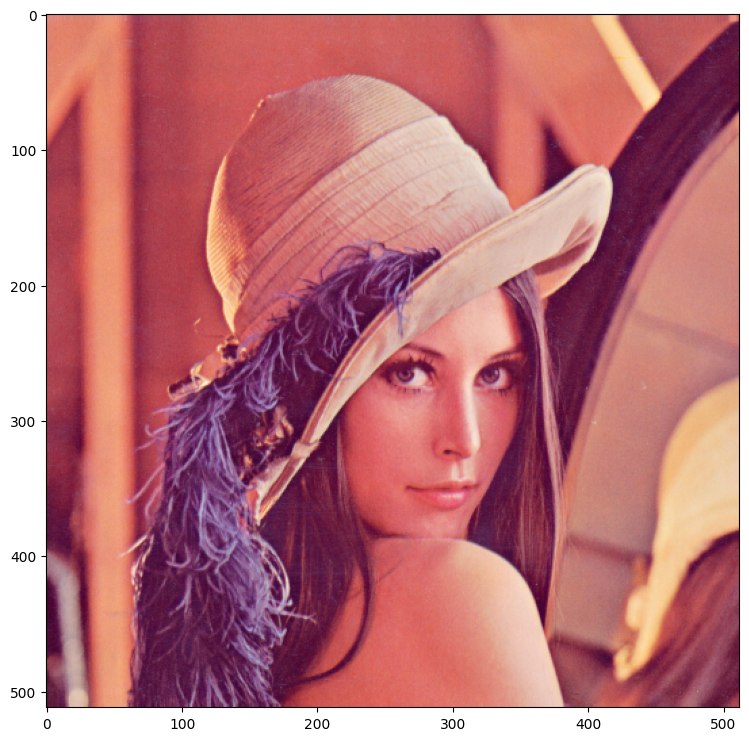

In [2]:
src_path: str = '.\\..\\resources\\img\\test\\Lenna.png'
# src_path: str = '.\\..\\resources\\not\\lenna_complete.jpg'

# CV2 reads the image in BGR format, while matplotlib expects RGB format
image = cv2.imread(src_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

segmented_image = image.copy()  # Create a copy of the original image to draw the segmentation result

mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Create an empty mask to keep track of the segmented region

plt.imshow(image)  # Display the original image (object)
plt.show()  # Display the original image (output)

Get the gray level image. The gray level image is used to compute the gradient.

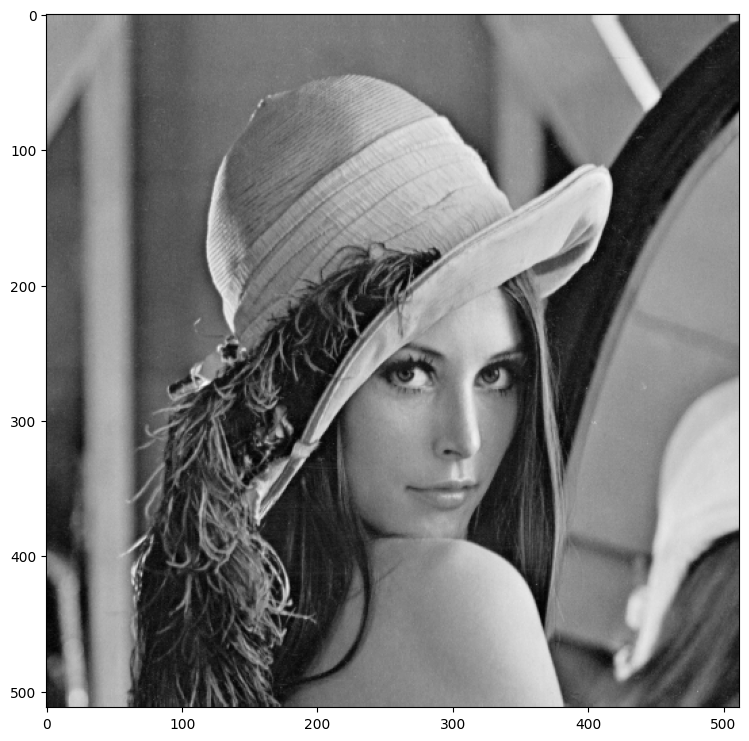

In [3]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, cmap='gray')  # Display the original image (object)
plt.show()  # Display the original image (output)

lower_threshold: 69.24465115928676
upper_threshold: 89.29911752107002


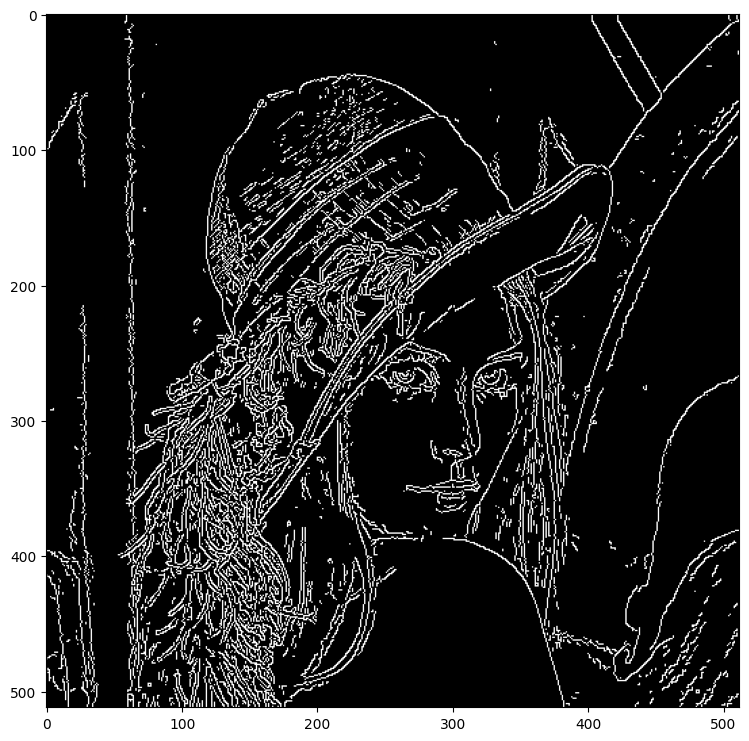

In [11]:
img_std = np.std(image)  # type: ignore
lower_threshold = image.mean() * 0.66
upper_threshold = image.mean() * 1.33
# lower_threshold = 30
# upper_threshold = 70
lower_threshold = image.mean() - img_std
upper_threshold = image.mean() - 0.66 * img_std

print(f'lower_threshold: {lower_threshold}')
print(f'upper_threshold: {upper_threshold}')

edges = cv2.Canny(gray_image, lower_threshold, upper_threshold)

# Display the image with the path
plt.imshow(edges, cmap='gray')  # Display the original image (object
plt.show()

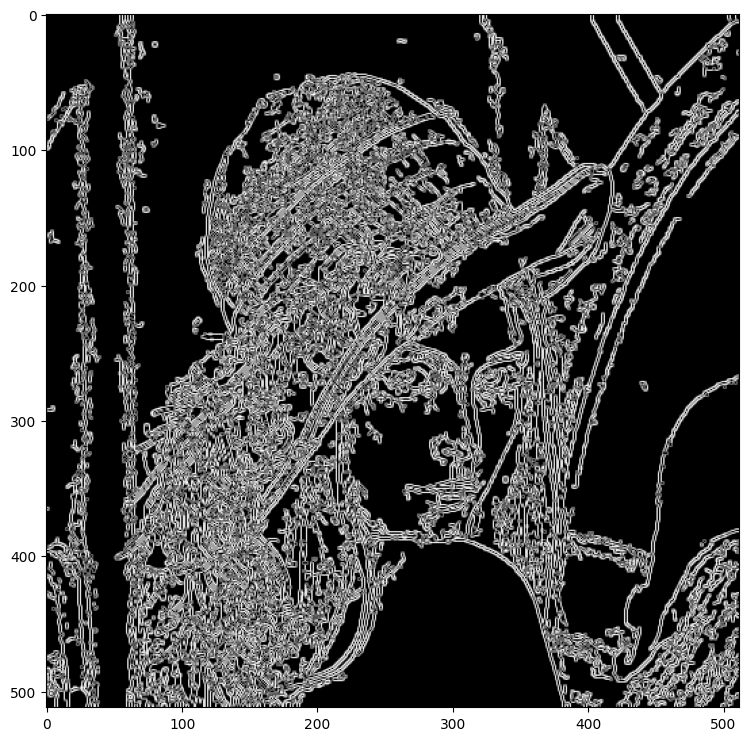

In [5]:
# Compute the gradient magnitude representation of the image
gradient_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)

# Calculate gradient magnitude and direction
# gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_direction = cv2.phase(gradient_x, gradient_y)

# Show the gradient magnitude and direction
plt.imshow(gradient_magnitude, cmap='gray')
plt.show()

To get the cost matrix, we use the gradient of the image. The gradient is computed using the Sobel operator.

The Sobel operator is a discrete differentiation operator. It computes an approximation of the gradient of the image intensity function.

It measures the first derivative in the horizontal direction $G_x$ and the vertical direction $G_y$.

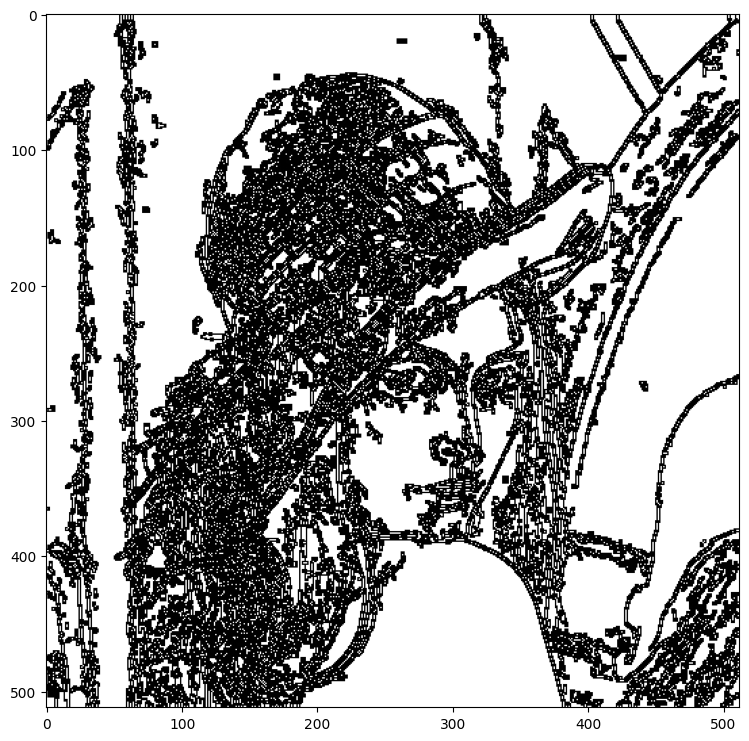

In [6]:
def compute_cost_matrix(gradient_magnitude, gradient_direction):
    """
    Compute the cost matrix for the graph cut algorithm.
    
    The cost is defined as the sum of the gradient magnitude and the gradient direction.
    """
    # * These values are mentioned in the paper. It seems to work well with a wide range of images.
    alpha = 0.43
    beta = 0.14
    gamma= 0.43

    height, width = gradient_magnitude.shape  # Get image dimensions
    cost_matrix = np.zeros((height, width))  # Initialize the cost matrix with zeros

    for y in range(height):  # For each row
        for x in range(width):  # For each column
            laplacian_cost = alpha * (1 - np.tanh(gradient_magnitude[y, x] / 255.0))  # Zero-crossing cost
            gradient_cost = beta * gradient_magnitude[y, x]  # Gradient cost
            direction_cost = gamma * (1 - np.cos(gradient_direction[y, x]))  # Direction cost 

            cost_matrix[y, x] = 1.0 / (gradient_cost + direction_cost + laplacian_cost + 1e-6)
            # add 1e-6 to avoid division by zero
    return cost_matrix  # Return the cost matrix

cost_matrix = compute_cost_matrix(gradient_magnitude, gradient_direction)

plt.imshow(cost_matrix, cmap='gray')
plt.show()

In [7]:
import networkx
    
# NetworkX is a Python library for studying graphs and networks.
# https://networkx.github.io/documentation/stable/index.html

# This function finds the minimum cost path between two points in the image 
def find_minimum_cost_path(cost_matrix, start_point, end_point):
    height, width = cost_matrix.shape
    G = networkx.Graph()

    # Add nodes to the graph
    for y in range(height):  # For all columns
        for x in range(width):  # For all rows
            G.add_node((y, x))  # Add the node to the graph

    neighbors = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
        ]  # Define neighbors for 8-connected pixels

    for y in range(height):  # For all columns
        for x in range(width):  # For all rows
            for dy, dx in neighbors:  # Add edges between neighboring pixels
                ny, nx = y + dy, x + dx  # Calculate the neighbor's coordinates
                if 0 <= ny < height and 0 <= nx < width:  # Check if the neighbor is within the image
                    G.add_edge((y, x), (ny, nx), weight=cost_matrix[y, x])  # Add the edge to the graph

    try:  # Find the shortest path using Dijkstra's algorithm
        return networkx.shortest_path(G, source=start_point, target=end_point, weight='weight')
    except networkx.NetworkXNoPath:  # If the path does not exist
        return []  # Return an empty path

In [8]:
import heapq

# Own implementation of Dijkstra's algorithm
def dijkstra(cost_matrix, start, end):
    # Get dimensions of the cost matrix
    height, width = cost_matrix.shape

    # Create a 2D array to track visited nodes
    visited = np.zeros((height, width), dtype=bool)

    # Create a 2D array to store the minimum cost to reach each pixel
    min_cost = np.inf * np.ones((height, width))

    # Initialize the starting point
    min_cost[start[0], start[1]] = 0

    # Create a priority queue to store pixels and their costs
    priority_queue = [(0, start)]

    # Define possible moves (8-connectivity)
    moves = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    while priority_queue:
        # Get the pixel with the minimum cost
        current_cost, (y, x) = heapq.heappop(priority_queue)

        # Mark the pixel as visited
        visited[y, x] = True

        # Check if we reached the end point
        if (y, x) == end:
            break

        # Explore neighbor pixels
        for dy, dx in moves:
            ny, nx = y + dy, x + dx

            # Check if the neighbor is within bounds
            if 0 <= ny < height and 0 <= nx < width and not visited[ny, nx]:
                # Calculate the cost to reach the neighbor
                neighbor_cost = current_cost + cost_matrix[ny, nx]

                # If the new cost is lower than the current cost, update it
                if neighbor_cost < min_cost[ny, nx]:
                    min_cost[ny, nx] = neighbor_cost
                    heapq.heappush(priority_queue, (neighbor_cost, (ny, nx)))

    # Backtrack to find the path
    path = []
    y, x = end
    while (y, x) != start:
        path.append((y, x))
        for dy, dx in moves:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and min_cost[y, x] == min_cost[ny, nx] + cost_matrix[y, x]:
                y, x = ny, nx
                break
    path.append(start)
    path.reverse()

    return path

(0, 0) -> (100, 100)
(100, 100) -> (500, 200)
(500, 200) -> (300, 500)


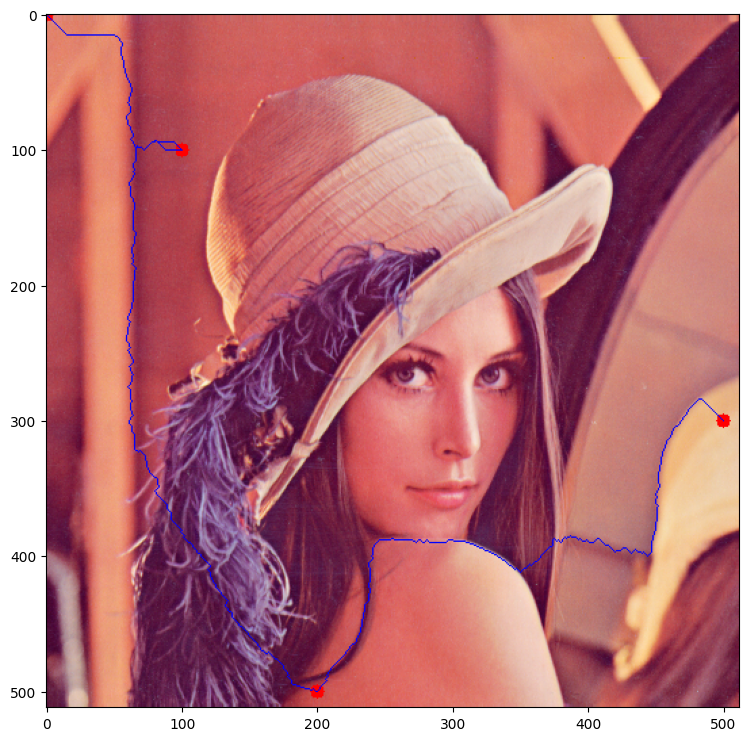

In [9]:
def draw_path(cost_matrix, route: tuple[int, int]):
    """
    This function takes an image and a route and draws the route to follow on the image.
    
    The route is a list of (y, x) coordinates.
    
    This funciton zip in pairs the coordinates of the route and draws a line between them.

    Ex : route = [(0, 0), (1, 1), (2, 2), (78, 32)]
    -> dijkstra(cost_matrix, (0, 0), (1, 1))
    -> dijkstra(cost_matrix, (1, 1), (2, 2))
    -> dijkstra(cost_matrix, (2, 2), (78, 32))

    
    ### Returns:
    - The image with the route drawn on it.
    """
    route_image = image.copy()

    for coord in route:
        coord = coord[::-1]  # Invert the coordinates (y, x) -> (x, y)
        cv2.circle(route_image, coord, 5, (255, 0, 0), -1)

    for start_point, end_point in zip(route[:-1], route[1:]):
        print(f'{start_point} -> {end_point}')
        path = dijkstra(cost_matrix, start_point, end_point)
        # path = find_minimum_cost_path(cost_matrix, start_point, end_point)
        # ^ Check why the x and y are inverted (y, x) instead of (x, y)
        for x, y in path: route_image[x, y] = [0,0, 255]

    return route_image  # Return the image with the route drawn on it


# * IMPORTANT *
# * IMPORTANT *
# * IMPORTANT *
# * IMPORTANT *
# * IMPORTANT *
# * These coordinates are inverted (y, x) instead of (x, y). So, when you use them, you have to invert them again.

test_path = ((0, 0), (100, 100), (500, 200), (300, 500))
# test_path = ((0, 0), (500, 300), (1000, 600))

# Draw the path on the image
route_image = draw_path(cost_matrix, test_path)

# Display the image with the path
plt.imshow(route_image)
plt.show()